<div style="display: block; width: 100%; text-align: center">
    <h2><font color="orange">Quantum Walk</font> <font color="tomato">Foundation</font></h2>
</div>

<div style="display: block; width: 100%; text-align: center">
    <h3><font color="olive">1. Classical random walks centers around the starting point</h3>
</div>

> Random walks are pretty intuitive. For a one-dimensional discrete time random walk, we have a walker, a coin and a number line to walk on. The walker tosses the coin, and based on the outcome of the toss, he decides whether to go left $(\text{current position} - 1)$ in the number line or to go right $(\text{current position} + 1)$. Both, classical and quantum versions of this random walk is implemented in this notebook.

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, BasicAer, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [37]:
def random_walk(i=0, N=100, pr=0.5):
    '''
        @param N   number of trials
        @param pr  the probability of choosing HEAD (going to right direction)
        @param i   initial position of the walker
        @returns pos  the final position of the walker
    '''
    position = i
    for i in range(N):
        choice = np.random.choice([0, 1], p=[pr, 1-pr])    # 0 represents HEAD and 1 TAIL
        position = position+1 if choice == 0 else position-1
    return position

In [38]:
def run(runs=100):
    positions = range(-runs, runs+1)
    instances = [0 for i in range(-runs, runs+1)]
    for i in range(runs):
        result = random_walk(i=-20, N=runs, pr=0.5)
        instances[positions.index(result)] += 1
    
    plt.bar(positions, [n/runs for n in instances])
    plt.xlabel("Positions")
    plt.ylabel("Probabilities")
    plt.grid()
    plt.title("Probabilities of finding the walker on different positions\n in the number line for a classical random walk")
    plt.show()

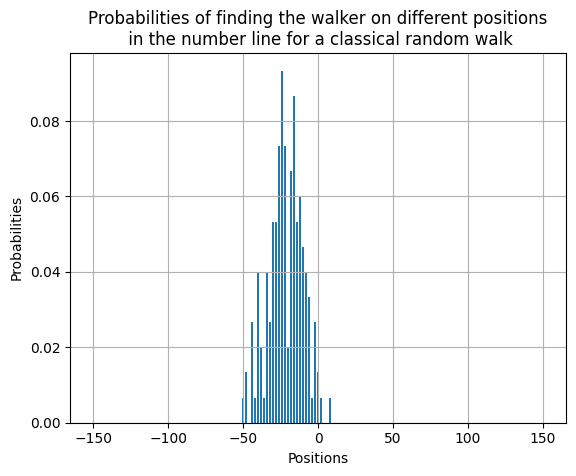

In [39]:
run(runs=150)

<div style="display: block; width: 100%; text-align: center">
    <h3><font color="orchid">2. Quantum walk goes far away from starting point</h3>
</div>

> ### The overall steps are
> - Toss the coin where the coin can be any type of coin (Hadamard, Grover or Fourier) but here for simplicity we have considered the Hadamard coin.
> - Build a circuit to make the walker go right on HEAD. On the number line, on which our quantum walker is going to walk, it can be thought of as incrementing the present state by 1. For example, from 0 to 1, from 1 to 2 and so on is essentially going right.
> - Similarly, for going left on TAIL, we need a circuit.
> - Repeat the steps.
>
> To do all these, we need a representation of the positions on the number line and the coin to follow. We are following the representation shown in this paper [Jayakody, M. N., Meena, C., & Pradhan, P. (2021). One-dimensional discrete-time quantum walks with general coin. ArXiv. /abs/2102.07207](https://arxiv.org/abs/2102.07207v1).
> 
> In a nutshell:
> - Suppose there are five steps in the number line, so they used five qubits to represent the position.
>     - $0=\ket{00100},$
>     - $-1=\ket{01000}, +1=\ket{00010},$
>     - $-2=\ket{10000}, +2=\ket{00001}$
>
>   This is a not very good approach to represent the position. We can have $2^5$ distinct combinations but here we can only represent $5$ positions. However, this is good for starters and the circuit where we actually can represent $2^n$ positions with $n$ qubits can be found here: [Implementation of Quantum Walks on Cycle Graph](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/terra/qis_adv/quantum_walk.ipynb).
> - To represent the coin, one qubit is enough as it is a one dimensional walk and there can only be either HEAD ($\ket{H}$) or TAIL ($\ket{T}$). And as mentioned above, we have used the Hadamard coin for simplicity.
> - If $\ket{coin}=\ket{H}$, $\ket{x}=\ket{x+1}$, and\
>   if $\ket{coin}=\ket{T}$, $\ket{x}=\ket{x-1}$\
>   where $x$ represents the position of the walker.
> - We need to implement circuits for those increment and decrement operation.
>

> ### Circuit for Increment & Decrement operation
> The circuit shown below increments $\ket{10000}$ into $\ket{01000}$, $\ket{01000}$ into $\ket{00100}$ and so on.
> ![Circuit to increment current state](QWImages/increment.png "Circuit to increment current state")
> 
> And, this circuit decrements $\ket{00001}$ into $\ket{00010}$, $\ket{00010}$ into $\ket{00100}$ and so on.
> ![Circuit to decrement current state](QWImages/decrement.png "Circuit to decrement current state")

In [40]:
def prepare_increment(circuit):
    """
    @param circuit the quantum circuit object
    """
    circuit.barrier()
    q = circuit.qubits
    coin = q[len(q)-1]
    N = len(q)-1
    
    for i in range(N-1):
        circuit.ccx(coin, q[i+1], q[i])
    for i in range(N-1):
        circuit.ccx(coin, q[i], q[i+1])
    return circuit

def prepare_decrement(circuit):
    circuit.barrier()
    q = circuit.qubits
    coin = q[len(q)-1]
    N = len(q)-1

    circuit.x(coin)
    for i in range(N-1, 0, -1):
        circuit.ccx(coin, q[i-1], q[i])
    for i in range(N-1, 0, -1):
        circuit.ccx(coin, q[i], q[i-1])
    return circuit

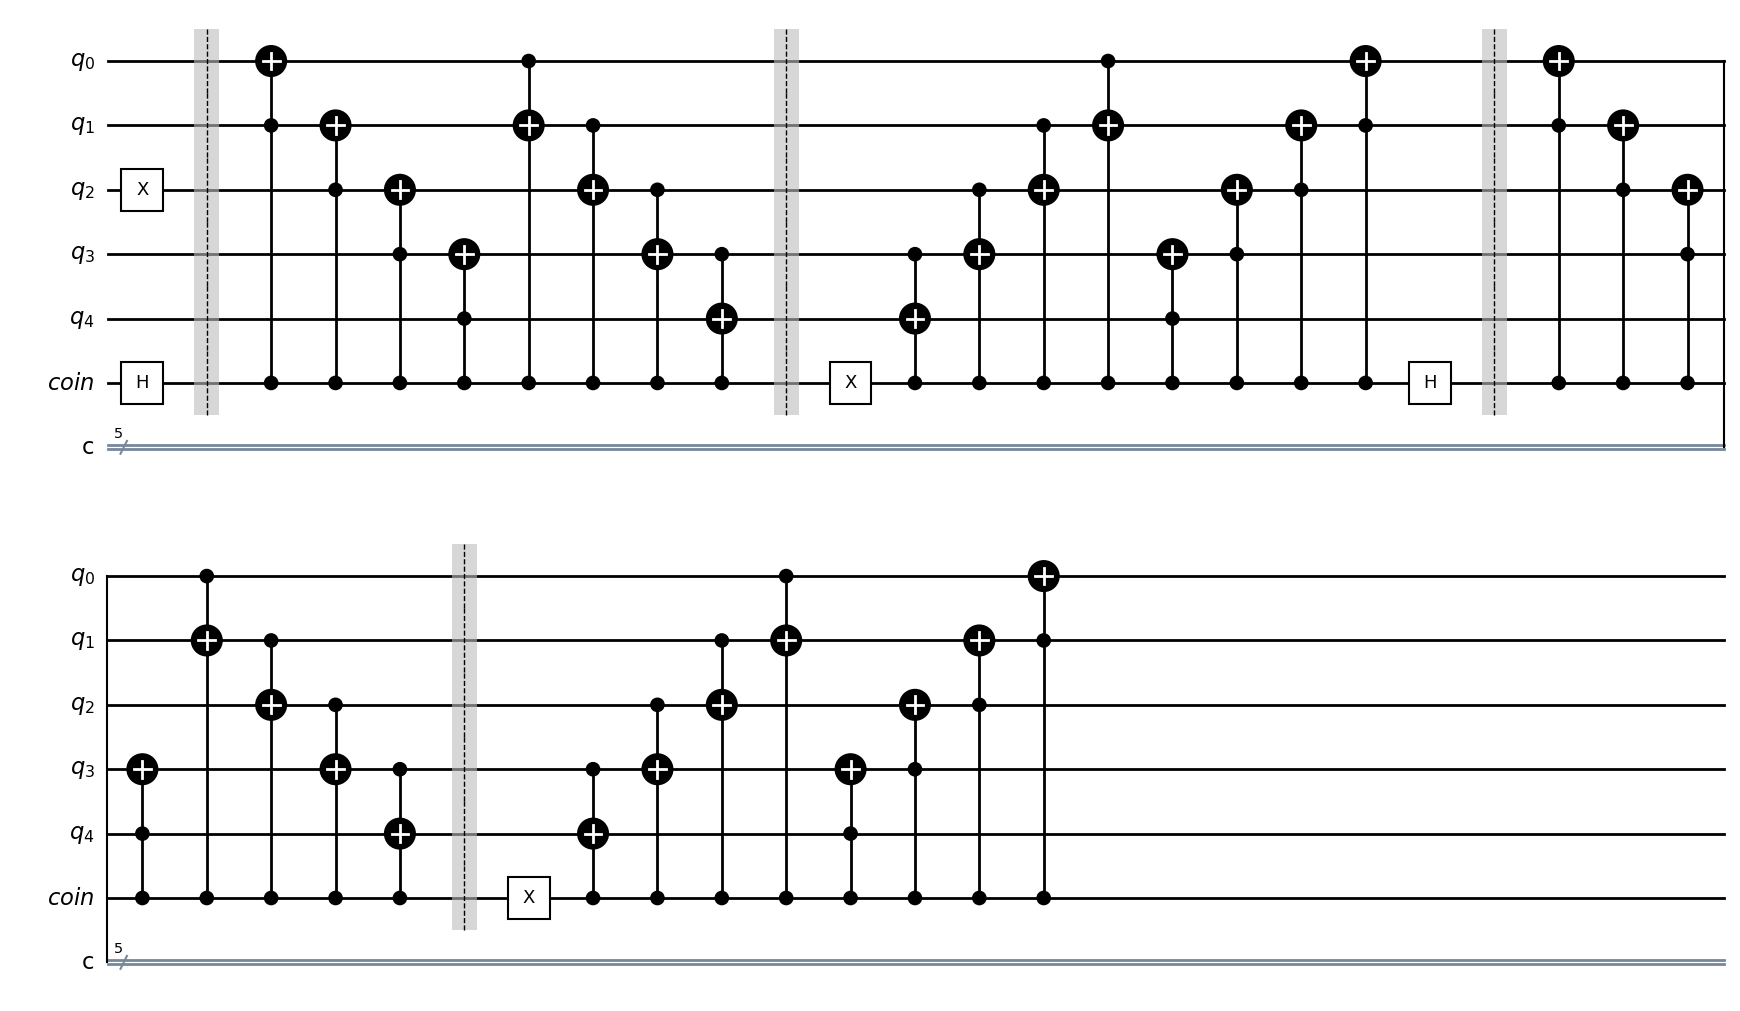

In [41]:
def prepare_circuit(N):
    """
    @param N the number of qubits to represent the position state
    @returns circuit the quantum circuit
    """
    coin = QuantumRegister(1, 'coin')
    q = QuantumRegister(N, 'q')
    c = ClassicalRegister(N, 'c')
    circuit = QuantumCircuit(q, coin, c)
    circuit.x(q[N//2])

    for i in range(N//2):
        circuit.h(coin)    # toss the hadamard coin
        circuit = prepare_increment(circuit)    # prepare the circuit for moving right in case of HEAD
        circuit = prepare_decrement(circuit)    # prepare the circuit for moving left in case of TAIL
    
    return circuit

N = 5    # this should be odd
ckt = prepare_circuit(N)
ckt.draw('mpl', style='bw')

In [42]:
initial_state = '0'
for i in range(N): initial_state += '0'
# print(initial_state)

state = Statevector.from_label(initial_state)
state = state.evolve(ckt)
state.draw('latex')
# plot_bloch_multivector(state)

<IPython.core.display.Latex object>

In [43]:
measured = ckt
for i in range(len(measured.qubits)-1):
    measured.measure(i, i)
# measured.draw(output='mpl', style='bw')

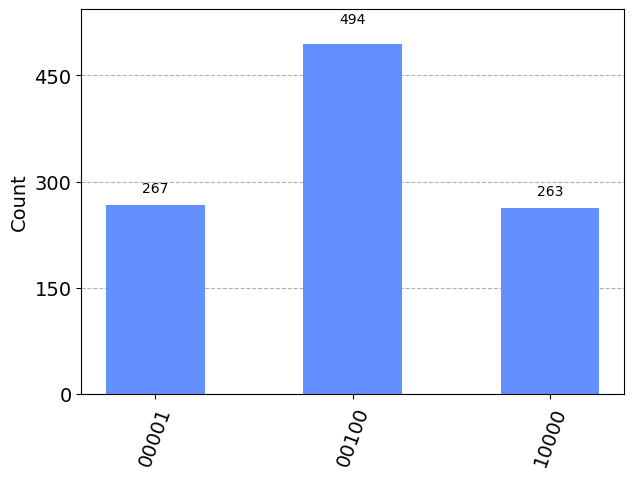

In [44]:
backend = BasicAer.get_backend('qasm_simulator')
circuit_compiled = transpile(ckt, backend)
simulator = backend.run(circuit_compiled, shots=1024)
result = simulator.result()
counts = result.get_counts(circuit_compiled)
plot_histogram(counts)

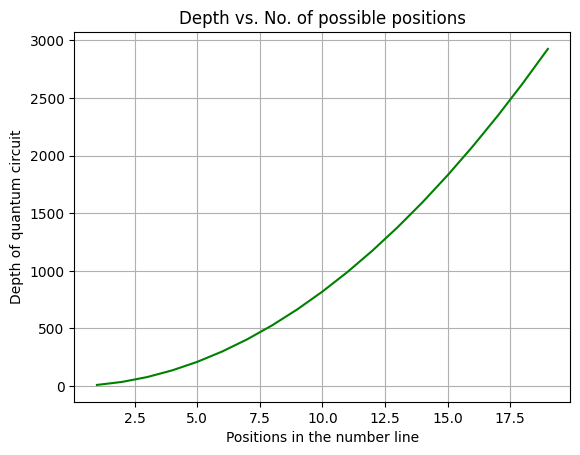

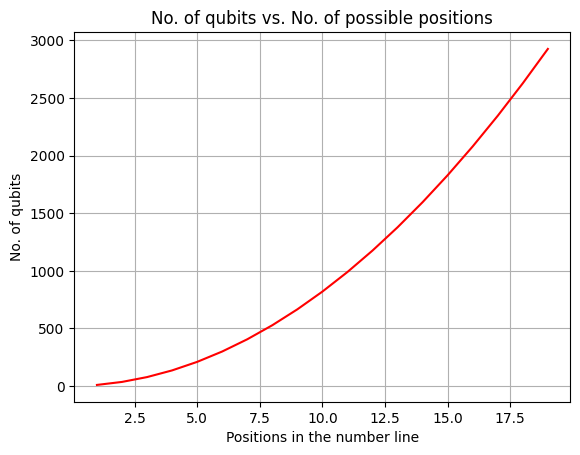

In [45]:
depths, n_qubits, low, high = [], [], 1, 20
for i in range(low, high):
    N = 2*i+1
    ckt = prepare_circuit(N)
    depths.append(ckt.depth())
    n_qubits.append(len(ckt.qubits))
    
plt.plot([i for i in range(low, high)], depths, c='green')
plt.xlabel("Positions in the number line")
plt.ylabel("Depth of quantum circuit")
plt.title("Depth vs. No. of possible positions")
plt.grid()
plt.show()

plt.plot([i for i in range(low, high)], depths, c='red')
plt.xlabel("Positions in the number line")
plt.ylabel("No. of qubits")
plt.title("No. of qubits vs. No. of possible positions")
plt.grid()
plt.show()